In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import FloatType
import pyspark.sql.functions as f
from pyspark.sql import Row
from pyspark import StorageLevel
from pyspark.sql import SparkSession
import sys
import numpy as np
import matplotlib.pylab as plt

In [2]:
# sc = SparkContext("local[*]", "NFL")
# rdd = sc.textFile('../in/PlayerTrackData.csv')

# remove header
# rdd = rdd.filter(lambda x: 'PlayKey' not in x)

# split the col
# rdd = rdd.map(lambda x: x.split(','))

# remove row if missing some value
# rdd = rdd.filter(lambda x: x[5] != '' and x[7] != '')

# convert to dataframe object
# sqlContext = SQLContext(sc)
# df = rdd.toDF(['PlayKey','time','event','x','y','dir','dis','o','s'])

# if df want to use rdd function
# just df.rdd.xxx()

In [2]:
spark = SparkSession.builder.master("local[*]").appName("NFL").getOrCreate()
tracks = spark.read.option("header",True).csv('../in/PlayerTrackData.csv')

In [3]:
# show header
# rdd.take(1)
# show schema
tracks.printSchema()

root
 |-- PlayKey: string (nullable = true)
 |-- time: string (nullable = true)
 |-- event: string (nullable = true)
 |-- x: string (nullable = true)
 |-- y: string (nullable = true)
 |-- dir: string (nullable = true)
 |-- dis: string (nullable = true)
 |-- o: string (nullable = true)
 |-- s: string (nullable = true)



In [4]:
# convert the defautl datatype
tracks = tracks.withColumn("time", tracks.time.cast('float').alias("time"))
tracks = tracks.withColumn("x", tracks.x.cast('float').alias("x"))
tracks = tracks.withColumn("y", tracks.y.cast('float').alias("y"))
tracks = tracks.withColumn("dir", tracks.dir.cast('float').alias("dir"))
tracks = tracks.withColumn("o", tracks.o.cast('float').alias("o"))
tracks = tracks.withColumn("s", tracks.s.cast('float').alias("s"))
tracks = tracks.withColumn("x", tracks.x.cast('float').alias("x"))

In [5]:
tracks.printSchema()

root
 |-- PlayKey: string (nullable = true)
 |-- time: float (nullable = true)
 |-- event: string (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- dir: float (nullable = true)
 |-- dis: string (nullable = true)
 |-- o: float (nullable = true)
 |-- s: float (nullable = true)



In [6]:
# get all ball_snap play record
ball_snap_tracks = tracks.where("event == 'ball_snap'")

# rename x,y,time for ball snap
drop_list = ['dir','dis','o','event','s']
ball_snap_tracks = ball_snap_tracks.withColumnRenamed('x','snap_x')\
.withColumnRenamed('y','snap_y')\
.withColumnRenamed('time','snap_time').drop(*drop_list)

# join two table (orign tracks and tracks only contained ball_snap event)
tracks = tracks.join(ball_snap_tracks, ['PlayKey'], "left_outer")

# remove any data for a play 0.1 second before snap
tracks = tracks.where('time >= (snap_time - 0.1)')


In [7]:
# get the last event of each play key
last_event_tracks = tracks.where('event is not null').groupBy('PlayKey').agg(f.max('time').alias('time'))

# join last event tracks and tracks
# only get the playkey, time, and event field
last_event_tracks = last_event_tracks.join(tracks, ['PlayKey','time'], "inner")[['PlayKey','time','event']]

# rename the column
last_event_tracks = last_event_tracks.withColumnRenamed('time','last_time').withColumnRenamed('event','last_event')

# park the result of last event tracks to the tracks
tracks = tracks.join(last_event_tracks, ['PlayKey'], 'left_outer')

# Remove any data for a play 0.1 second after last event
tracks = tracks.where('time <= (last_time + 0.1)')

In [8]:
tracks.printSchema()

root
 |-- PlayKey: string (nullable = true)
 |-- time: float (nullable = true)
 |-- event: string (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- dir: float (nullable = true)
 |-- dis: string (nullable = true)
 |-- o: float (nullable = true)
 |-- s: float (nullable = true)
 |-- snap_time: float (nullable = true)
 |-- snap_x: float (nullable = true)
 |-- snap_y: float (nullable = true)
 |-- last_time: float (nullable = true)
 |-- last_event: string (nullable = true)



In [9]:
# save tracks into memory
# only record the time from the start of first event-1 to the end of last event+1
tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[PlayKey: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string]

In [10]:
pd = tracks.where('event == "ball_snap"').toPandas()

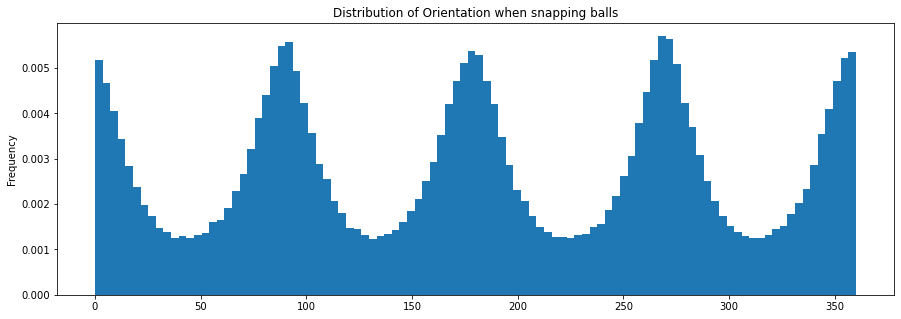

In [21]:
pd['o'].plot(kind='hist',
             bins=100,
             figsize=(15, 5),
             density=True,
             title='Distribution of Orientation when snapping balls')
plt.savefig('../out/o_hist.png')

In [11]:
# tracks.show()
# print(tracks.count())

In [10]:
#load play list data
playlist = spark.read.option("header",True).csv('../in/PlayList.csv')

# convert player day to integer
playlist = playlist.withColumn("PlayerDay", playlist.PlayerDay.cast('int').alias("PlayerDay"))

In [11]:
playlist.printSchema()

root
 |-- PlayerKey: string (nullable = true)
 |-- GameID: string (nullable = true)
 |-- PlayKey: string (nullable = true)
 |-- RosterPosition: string (nullable = true)
 |-- PlayerDay: integer (nullable = true)
 |-- PlayerGame: string (nullable = true)
 |-- StadiumType: string (nullable = true)
 |-- FieldType: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Weather: string (nullable = true)
 |-- PlayType: string (nullable = true)
 |-- PlayerGamePlay: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- PositionGroup: string (nullable = true)



In [12]:
# get season 2 distinct player key
tough_playerkey = playlist.select('PlayerKey').where('PlayerDay >= 350').distinct()
tough_playerkey = tough_playerkey.rdd.map(lambda x:x.PlayerKey).collect()

In [13]:
# only select the player who play in season 2, dont know is he play season 1
tough_playlist = playlist[playlist.PlayerKey.isin(tough_playerkey)]

# add season to df, if less than 350, season 1 else season 2
tough_playlist = tough_playlist.withColumn('season', f.when(f.col("PlayerDay") < 350,1).otherwise(2))

In [14]:
games = tough_playlist[['GameID','season']].distinct()

In [15]:
_tracks = tracks.join(tough_playlist[['PlayKey','GameID']],['PlayKey'],'left_outer')
_tracks = _tracks.join(games,['GameID'],'left_outer')
_tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[GameID: string, PlayKey: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string, season: int]

In [16]:
# Fix orientation
# Assume other seasons based on direction at snap - if orientation at snap is outside normal range, shift.
s1 = _tracks.select('PlayKey').where('event == "ball_snap" and o < 50 and season is null').distinct().collect()
s2 = _tracks.select('PlayKey').where('event == "ball_snap" and o > 325 and season is null').distinct().collect()
s3 = _tracks.select('PlayKey').where('event == "ball_snap" and o < 225 and o > 125 and season is null').distinct().collect()

def get(x, field='PlayKey'):
    return [i[field] for i in x]

abnormal_playkey = get(s1)+get(s2)+get(s3)
abnormal_playkey = list(set(abnormal_playkey))

In [17]:
# all abnormal orientation record will be treated as session 1
tracks = _tracks.withColumn('season', 
                            f.when(_tracks.season.isNull()
                                   & _tracks.PlayKey.isin(abnormal_playkey),1).otherwise(f.col('season')))

# all normal orientation record will be treated as session 2
tracks = tracks.withColumn('season', 
                           f.when(tracks.season.isNull()
                                  & ~tracks.PlayKey.isin(abnormal_playkey),2).otherwise(f.col('season')))
# tracks.persist(StorageLevel.MEMORY_ONLY)

In [18]:
# Change orientation for season 1
clean_tracks = tracks.withColumn('o',f.when(f.col('season')== 1, (f.col('o')+90)%360).otherwise(f.col('o')))
# clean_tracks.persist(StorageLevel.MEMORY_ONLY)

In [19]:
# join clean track and playlist
tracks = clean_tracks.join(playlist[['PlayKey','PlayerKey','RosterPosition','PositionGroup','FieldType','PlayType']], ['PlayKey'], 'inner')

In [20]:
tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[PlayKey: string, GameID: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string, season: int, PlayerKey: string, RosterPosition: string, PositionGroup: string, FieldType: string, PlayType: string]

In [21]:
pd = tracks.where('event == "ball_snap"').toPandas()

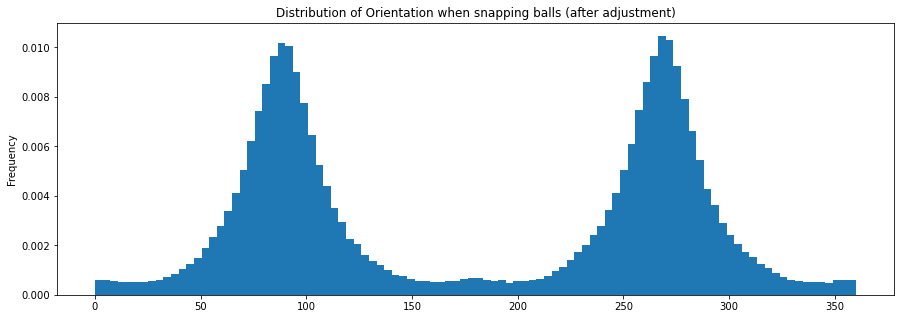

In [22]:
pd['o'].plot(kind='hist',
             bins=100,
             figsize=(15, 5),
             density=True,
             title='Distribution of Orientation when snapping balls (after adjustment)')
plt.savefig('../out/adjust_o_hist.png')

In [36]:
pd.query('o > 360')

,PlayKey,GameID,time,event,x,y,dir,dis,o,s,...,snap_x,snap_y,last_time,last_event,season,PlayerKey,RosterPosition,PositionGroup,FieldType,PlayType
11,27363-10-71,27363-10,16.0,ball_snap,67.510002,29.629999,267.700012,0.0,447.329987,0.65,...,67.510002,29.629999,23.900000,tackle,1,27363,Quarterback,QB,Synthetic,Rush
27,30953-4-13,30953-4,14.3,ball_snap,35.919998,27.650000,55.709999,0.11,447.100006,1.42,...,35.919998,27.650000,18.700001,tackle,1,30953,Linebacker,LB,Natural,Rush
34,31266-1-5,31266-1,16.0,ball_snap,25.070000,35.529999,149.619995,0.0,371.660004,0.29,...,25.070000,35.529999,20.600000,tackle,1,31266,Defensive Lineman,DL,Natural,Rush
41,31933-3-49,31933-3,19.6,ball_snap,79.269997,24.860001,33.799999,0.0,448.980011,0.10,...,79.269997,24.860001,26.900000,tackle,1,31933,Tight End,TE,Natural,Rush
43,32103-1-50,32103-1,18.6,ball_snap,40.860001,18.760000,56.549999,0.0,445.660004,0.85,...,40.860001,18.760000,26.400000,out_of_bounds,1,32103,Tight End,TE,Natural,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253398,46038-10-28,46038-10,11.1,ball_snap,58.779999,20.100000,288.570007,0.15,439.929993,1.37,...,58.779999,20.100000,15.300000,tackle,1,46038,Safety,DB,Natural,Pass
253409,46038-8-8,46038-8,20.9,ball_snap,18.809999,33.009998,49.599998,0.0,445.049988,0.02,...,18.809999,33.009998,55.799999,penalty_accepted,1,46038,Safety,DB,Synthetic,Rush
253416,46046-5-27,46046-5,11.7,ball_snap,73.930000,28.850000,34.650002,0.12,403.450012,1.55,...,73.930000,28.850000,17.799999,tackle,1,46046,Linebacker,LB,Natural,Rush
253431,46299-6-5,46299-6,16.0,ball_snap,32.430000,29.900000,139.179993,0.0,449.679993,1.56,...,32.430000,29.900000,21.000000,tackle,1,46299,Running Back,RB,Natural,Pass


In [21]:
#load injury data
injury = spark.read.option("header",True).csv('../in/InjuryRecord.csv')

injury_plays = injury.select('PlayKey').distinct().collect()
injury_plays = get(injury_plays)

injury_players = injury.select('PlayerKey').distinct().collect()
injury_players = get(injury_players, field='PlayerKey')

In [24]:
injury

DataFrame[PlayerKey: string, GameID: string, PlayKey: string, BodyPart: string, Surface: string, DM_M1: string, DM_M7: string, DM_M28: string, DM_M42: string]

In [25]:
playlist

DataFrame[PlayerKey: string, GameID: string, PlayKey: string, RosterPosition: string, PlayerDay: int, PlayerGame: string, StadiumType: string, FieldType: string, Temperature: string, Weather: string, PlayType: string, PlayerGamePlay: string, Position: string, PositionGroup: string]

In [48]:
playlist.groupBy(['playType']).count().collect()

[Row(playType='Kickoff', count=5754),
 Row(playType='Extra Point', count=5906),
 Row(playType='Kickoff Not Returned', count=4625),
 Row(playType='0', count=279),
 Row(playType=None, count=367),
 Row(playType='Punt Not Returned', count=3486),
 Row(playType='Field Goal', count=4915),
 Row(playType='Punt Returned', count=2469),
 Row(playType='Rush', count=92606),
 Row(playType='Kickoff Returned', count=2773),
 Row(playType='Punt', count=5746),
 Row(playType='Pass', count=138079)]

In [44]:
injury_playlist = injury.join(playlist, ['PlayKey'],'inner')

In [46]:
res = injury_playlist.groupby(['RosterPosition']).count()
res.collect()

[Row(RosterPosition='Linebacker', count=21),
 Row(RosterPosition='Defensive Lineman', count=7),
 Row(RosterPosition='Offensive Lineman', count=6),
 Row(RosterPosition='Running Back', count=6),
 Row(RosterPosition='Safety', count=11),
 Row(RosterPosition='Wide Receiver', count=16),
 Row(RosterPosition='Cornerback', count=8),
 Row(RosterPosition='Tight End', count=2)]

In [49]:
# only focus on 3 kind of position
# tracks = tracks.withColumn('isInjuryPronePos', 
#                            f.when(tracks.PositionGroup.isin(['DB','WR','LB']),True).otherwise(False))

tracks = tracks.withColumn('isInjuryPronePos', 
                           f.when(tracks.RosterPosition.isin(['Linebacker','Safety','Wide Receiver']),True).otherwise(False))

# is player get injuryed in the play
tracks = tracks.withColumn('isInjuryPlay', 
                           f.when(tracks.PlayKey.isin(injury_plays),True).otherwise(False))

# is player rush or pass
tracks = tracks.withColumn('isRushPass', 
                           f.when(tracks.PlayType.isin(['Rush','Pass']),True).otherwise(False))

# is player ever get injuryed
tracks = tracks.withColumn('isInjuredPlayer', 
                           f.when(tracks.PlayerKey.isin(injury_plays),True).otherwise(False))



In [50]:
# Time since the snap (only remain the record that with in 25 seconds start at snapping a ball)
tracks = tracks.withColumn('time_since_snap',tracks.time-tracks.snap_time)
tracks = tracks.where('time_since_snap <= 25')

In [51]:
tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[PlayKey: string, GameID: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string, season: int, PlayerKey: string, RosterPosition: string, PositionGroup: string, FieldType: string, PlayType: string, isInjuryPronePos: boolean, isInjuryPlay: boolean, isRushPass: boolean, isInjuredPlayer: boolean, time_since_snap: float]

In [53]:
# def getODirDiff(o,d):
#     diff1 = abs(o-d)
#     diff2 = abs(o-(d-360))
#     diff3 = abs(o-(d+360))
#     return min([diff1,diff2,diff3])
# fn = f.udf(getODirDiff, FloatType())
# _tracks = tracks.rdd.map(getODirDiff)

In [52]:
_tracks = tracks.withColumn('o_dir_diff1', f.abs(tracks.o-tracks.dir))
_tracks = _tracks.withColumn('o_dir_diff2', f.abs(_tracks.o-(_tracks.dir-360)))
_tracks = _tracks.withColumn('o_dir_diff3', f.abs(_tracks.o-(_tracks.dir+360)))
_tracks = _tracks.withColumn('o_dir_diff', f.least(_tracks.o_dir_diff1,_tracks.o_dir_diff2,_tracks.o_dir_diff3))

drop = ['o_dir_diff1', 'o_dir_diff2', 'o_dir_diff3']
_tracks = _tracks.drop(*drop)

In [53]:
# class the movement
_tracks = _tracks.withColumn('movement', 
                           f.when(f.col('o_dir_diff') >= 45, 'abnormal')\
                           .otherwise('normal'))

In [54]:
# label is abnormal movement
_tracks = _tracks.withColumn('is_abnormal_movement', 
                           f.when(f.col('movement') == 'normal', False)\
                           .otherwise(True))

_tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[PlayKey: string, GameID: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string, season: int, PlayerKey: string, RosterPosition: string, PositionGroup: string, FieldType: string, PlayType: string, isInjuryPronePos: boolean, isInjuryPlay: boolean, isRushPass: boolean, isInjuredPlayer: boolean, time_since_snap: float, o_dir_diff: float, movement: string, is_abnormal_movement: boolean]

In [61]:
t_group = _tracks.groupby(['isInjuryPlay','playType']).count()
c = t_group.collect()
print(c)

[Row(isInjuryPlay=False, playType='Punt', count=591146), Row(isInjuryPlay=True, playType='Punt Not Returned', count=114), Row(isInjuryPlay=False, playType='Pass', count=9309402), Row(isInjuryPlay=False, playType='Rush', count=4890474), Row(isInjuryPlay=True, playType='Pass', count=2349), Row(isInjuryPlay=False, playType='Field Goal', count=209663), Row(isInjuryPlay=False, playType='Punt Not Returned', count=304396), Row(isInjuryPlay=False, playType='Extra Point', count=229802), Row(isInjuryPlay=True, playType='Punt', count=1049), Row(isInjuryPlay=False, playType='Punt Returned', count=302231), Row(isInjuryPlay=True, playType='Punt Returned', count=348), Row(isInjuryPlay=False, playType='0', count=50316), Row(isInjuryPlay=True, playType='Rush', count=1088), Row(isInjuryPlay=False, playType=None, count=65781)]


In [55]:
# show the ratio between movement and injury (RosterPosition)
t_group = _tracks.where('isRushPass == True and isInjuryPronePos == True').groupby(['movement','isInjuryPlay']).count()
t_group.show()

+--------+------------+-------+
|movement|isInjuryPlay|  count|
+--------+------------+-------+
|abnormal|        true|    911|
|  normal|       false|4030912|
|  normal|        true|    874|
|abnormal|       false|2795604|
+--------+------------+-------+



In [117]:
# show the ratio between movement and injury
t_group = _tracks.where('isRushPass == True and isInjuryPronePos == True').groupby(['movement','isInjuryPlay']).count()
t_group.show()

+--------+------------+-------+
|movement|isInjuryPlay|  count|
+--------+------------+-------+
|abnormal|        true|   1225|
|  normal|       false|4721894|
|  normal|        true|   1102|
|abnormal|       false|3678244|
+--------+------------+-------+



In [56]:
# show the ratio between movement and injury and position (RosterPosition)
t_group = _tracks.where('isRushPass == True').groupby(['movement','isInjuryPlay','RosterPosition']).count()
t_group.show()
c = t_group.collect()
print(c)

+--------+------------+-----------------+-------+
|movement|isInjuryPlay|   RosterPosition|  count|
+--------+------------+-----------------+-------+
|abnormal|        true|       Cornerback|    314|
|abnormal|        true|           Safety|    297|
|abnormal|       false|     Running Back| 258160|
|  normal|        true|       Linebacker|    247|
|abnormal|        true|Defensive Lineman|    142|
|  normal|        true|       Cornerback|    228|
|abnormal|       false|       Linebacker|1101190|
|  normal|       false|Defensive Lineman| 987164|
|abnormal|       false|Offensive Lineman|1492667|
|  normal|        true|     Running Back|    373|
|abnormal|       false|           Safety| 999177|
|abnormal|       false|           Kicker|     78|
|abnormal|       false|    Wide Receiver| 695237|
|  normal|       false|       Linebacker|1304665|
|  normal|        true|        Tight End|     37|
|  normal|        true|    Wide Receiver|    457|
|  normal|        true|Defensive Lineman|    105|


In [57]:
c

[Row(movement='abnormal', isInjuryPlay=True, RosterPosition='Cornerback', count=314),
 Row(movement='abnormal', isInjuryPlay=True, RosterPosition='Safety', count=297),
 Row(movement='abnormal', isInjuryPlay=False, RosterPosition='Running Back', count=258160),
 Row(movement='normal', isInjuryPlay=True, RosterPosition='Linebacker', count=247),
 Row(movement='abnormal', isInjuryPlay=True, RosterPosition='Defensive Lineman', count=142),
 Row(movement='normal', isInjuryPlay=True, RosterPosition='Cornerback', count=228),
 Row(movement='abnormal', isInjuryPlay=False, RosterPosition='Linebacker', count=1101190),
 Row(movement='normal', isInjuryPlay=False, RosterPosition='Defensive Lineman', count=987164),
 Row(movement='abnormal', isInjuryPlay=False, RosterPosition='Offensive Lineman', count=1492667),
 Row(movement='normal', isInjuryPlay=True, RosterPosition='Running Back', count=373),
 Row(movement='abnormal', isInjuryPlay=False, RosterPosition='Safety', count=999177),
 Row(movement='abnormal

In [119]:
# show the ratio between movement and injury and position
t_group = _tracks.where('isRushPass == True').groupby(['movement','isInjuryPlay','PositionGroup']).count()
t_group.show()
c = t_group.collect()
print(c)

+--------+------------+-------------+-------+
|movement|isInjuryPlay|PositionGroup|  count|
+--------+------------+-------------+-------+
|  normal|        true|           DL|    105|
|abnormal|        true|           TE|     30|
|abnormal|       false|           DB|1857120|
|  normal|        true|           DB|    398|
|abnormal|        true|           LB|    328|
|  normal|        true|           OL|     81|
|  normal|        true|           RB|    373|
|  normal|       false|           QB| 164805|
|  normal|       false|           TE| 228398|
|  normal|       false|           DB|1582792|
|abnormal|       false|           TE| 156864|
|abnormal|       false|           WR| 695240|
|  normal|       false|           OL|1245230|
|abnormal|        true|           DL|    142|
|  normal|       false|           RB| 358384|
|  normal|       false|           WR|1804093|
|abnormal|       false|           DL| 684476|
|abnormal|       false|           OL|1492672|
|abnormal|       false|           

In [120]:
c

[Row(movement='normal', isInjuryPlay=True, PositionGroup='DL', count=105),
 Row(movement='abnormal', isInjuryPlay=True, PositionGroup='TE', count=30),
 Row(movement='abnormal', isInjuryPlay=False, PositionGroup='DB', count=1857120),
 Row(movement='normal', isInjuryPlay=True, PositionGroup='DB', count=398),
 Row(movement='abnormal', isInjuryPlay=True, PositionGroup='LB', count=328),
 Row(movement='normal', isInjuryPlay=True, PositionGroup='OL', count=81),
 Row(movement='normal', isInjuryPlay=True, PositionGroup='RB', count=373),
 Row(movement='normal', isInjuryPlay=False, PositionGroup='QB', count=164805),
 Row(movement='normal', isInjuryPlay=False, PositionGroup='TE', count=228398),
 Row(movement='normal', isInjuryPlay=False, PositionGroup='DB', count=1582792),
 Row(movement='abnormal', isInjuryPlay=False, PositionGroup='TE', count=156864),
 Row(movement='abnormal', isInjuryPlay=False, PositionGroup='WR', count=695240),
 Row(movement='normal', isInjuryPlay=False, PositionGroup='OL', co

In [58]:
# show the ratio between speed and injury
t_group = _tracks.select(['s','isInjuryPlay']).groupby('isInjuryPlay').agg(f.mean("s").alias('avg_speed'))
t_group.show()


+------------+-----------------+
|isInjuryPlay|        avg_speed|
+------------+-----------------+
|        true| 3.10926030685172|
|       false|2.653949671597476|
+------------+-----------------+



In [63]:
# show the ratio between speed and injury
# t_group = _tracks.select(['s','isInjuryPlay','PositionGroup']).groupby('isInjuryPlay','PositionGroup').agg(f.mean("s").alias('avg_speed'))
t_group = _tracks.select(['s','isInjuryPlay','RosterPosition']).groupby('isInjuryPlay','RosterPosition').agg(f.mean("s").alias('avg_speed'))
t_group.show()
c = t_group.collect()

+------------+-----------------+------------------+
|isInjuryPlay|   RosterPosition|         avg_speed|
+------------+-----------------+------------------+
|       false|       Cornerback|3.0783234981077943|
|       false|        Tight End|2.8337883323087016|
|       false|      Quarterback|1.7420485825848817|
|        true|       Cornerback|2.6128589395124004|
|        true|        Tight End|3.8832836008783596|
|        true|    Wide Receiver|3.6077649545252855|
|       false|    Wide Receiver|3.4822857157183225|
|        true|           Safety|2.8797391339521043|
|       false|Offensive Lineman|1.6539108777126899|
|       false|       Linebacker|2.7511054023236454|
|       false|     Running Back|3.0450795054005293|
|        true|Offensive Lineman|1.6694932395995066|
|       false|Defensive Lineman|2.0979293224867064|
|        true|       Linebacker| 3.426846961418319|
|        true|     Running Back|3.3406400055103003|
|       false|           Safety|2.9685911972882604|
|       fals

In [64]:
c

[Row(isInjuryPlay=False, RosterPosition='Cornerback', avg_speed=3.0783234981077943),
 Row(isInjuryPlay=False, RosterPosition='Tight End', avg_speed=2.8337883323087016),
 Row(isInjuryPlay=False, RosterPosition='Quarterback', avg_speed=1.7420485825848817),
 Row(isInjuryPlay=True, RosterPosition='Cornerback', avg_speed=2.6128589395124004),
 Row(isInjuryPlay=True, RosterPosition='Tight End', avg_speed=3.8832836008783596),
 Row(isInjuryPlay=True, RosterPosition='Wide Receiver', avg_speed=3.6077649545252855),
 Row(isInjuryPlay=False, RosterPosition='Wide Receiver', avg_speed=3.4822857157183225),
 Row(isInjuryPlay=True, RosterPosition='Safety', avg_speed=2.8797391339521043),
 Row(isInjuryPlay=False, RosterPosition='Offensive Lineman', avg_speed=1.6539108777126899),
 Row(isInjuryPlay=False, RosterPosition='Linebacker', avg_speed=2.7511054023236454),
 Row(isInjuryPlay=False, RosterPosition='Running Back', avg_speed=3.0450795054005293),
 Row(isInjuryPlay=True, RosterPosition='Offensive Lineman',

In [126]:
# show the ratio between movement and injury
t_group = _tracks.groupby(['movement','isInjuryPlay']).count()
t_group.show()

+--------+------------+-------+
|movement|isInjuryPlay|  count|
+--------+------------+-------+
|abnormal|        true|   2272|
|  normal|       false|8732590|
|  normal|        true|   2676|
|abnormal|       false|7220621|
+--------+------------+-------+



In [127]:
# show the ratio between movement and injury (no isInjuryPronePos)
t_group = _tracks.where('isRushPass == True').groupby(['movement','isInjuryPlay']).count()
t_group.show()

+--------+------------+-------+
|movement|isInjuryPlay|  count|
+--------+------------+-------+
|abnormal|        true|   1739|
|  normal|       false|7677686|
|  normal|        true|   1698|
|abnormal|       false|6522190|
+--------+------------+-------+



In [100]:
# speed
# player_mean_speed_df = df.rdd.map(lambda x: [x[0].split('-')[0], float(x[-1])]).toDF(["playerKey","s"])
# # remove extreme small speed
# player_mean_speed_df = player_mean_speed_df.rdd.filter(lambda x:x.s >= 1).toDF(["playerKey","s"])
# # get average speed
# player_mean_speed = player_mean_speed_df.groupBy('playerKey').agg(f.mean("s").alias('mean'))
# result = player_mean_speed.collect()

In [90]:
# add new col.
# compute the difference between o and dir
# def add_o_dir_diff(x):
#     x = x.asDict()
#     x['o_dir_diff'] = min([abs(x['o']-x['dir']),abs(x['o']-(x['dir']-360)),abs(x['o']-(x['dir']+360))])
    
#     x['is_forward_move'] = False
#     x['is_sideway_move'] = False
#     x['is_backward_move'] = False
    
#     if x['o_dir_diff'] <= 45:
#         x['move_type'] = 'forward'
#         x['is_forward_move'] = True
#     elif x['o_dir_diff'] <= 135:
#         x['move_type'] = 'sideway'
#         x['is_sideway_move'] = True
#     else:
#         x['move_type'] = 'backward'
#         x['is_backward_move'] = True
        
#     return Row(**x)


# rdd = df.rdd.map(add_o_dir_diff)
# df = rdd.toDF()